In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Save references to each table
Measurement= Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.id, Measurement.date).order_by(Measurement.date.asc()).first()
print(recent_date.date)

2010-01-01


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
prcp = session.query(Measurement.date, Measurement.prcp).\
    order_by(Measurement.date.asc()).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp, columns=['date', 'prcp'])
prcp_df =prcp_df.dropna(subset=['prcp'])
prcp_df['date']=pd.to_datetime(prcp_df['date'])
prcp_df.set_index('date', inplace=True)
prcp_df

,prcp
date,
2010-01-01,0.08
2010-01-01,0.28
2010-01-01,0.21
2010-01-01,0.15
2010-01-01,0.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


In [14]:
#group by month
prcp_groupbydate=prcp_df.groupby(prcp_df.index.month).head(1).reset_index()
# Sort the dataframe by date
prcp_groupbydate['date']=prcp_groupbydate['date'].dt.date
prcp_groupbydate= prcp_groupbydate.sort_values(by='date', ascending=True)
prcp_groupbydate.set_index('date', inplace=True)
prcp_groupbydate

,prcp
date,
2010-01-01,0.08
2010-02-01,0.01
2010-03-01,0.01
2010-04-01,0.00
2010-05-01,0.00
2010-06-01,0.00
2010-07-01,0.01
2010-08-01,0.04
2010-09-01,0.00


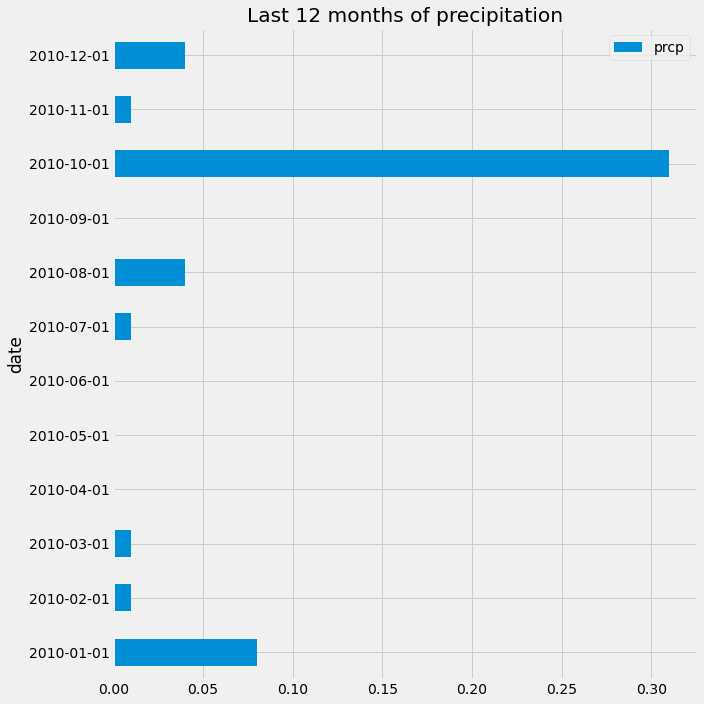

In [15]:
# Plot the dataframe as a horizontal bar chart using pandas plotting
prcp_groupbydate.plot.barh(figsize=(10,10), title="Last 12 months of precipitation")
plt.tight_layout()
plt.show()


In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_statistics = prcp_df["prcp"].describe()
summaryst_df = pd.DataFrame(summary_statistics)
summaryst_df.rename(columns = {"prcp": "precipitation"})

,precipitation
count,18103.000000
mean,0.160644
std,0.468746
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,11.530000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
station_num = session.query(func.count(Station.id)).all()
print(station_num)

[(9,)]


In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_rows = session.query(Measurement.station, func.count(Measurement.date)).group_by(Measurement.station).order_by(func.count(Measurement.date).desc()).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
station_df = pd.DataFrame(station_rows, columns=['station','count'])
print(station_df)
active_station = station_df.loc[0][0]
print('The Most Active Station is: ',active_station)

       station  count
0  USC00519281   2772
1  USC00519397   2724
2  USC00513117   2709
3  USC00519523   2669
4  USC00516128   2612
5  USC00514830   2202
6  USC00511918   1979
7  USC00517948   1372
8  USC00518838    511
The Most Active Station is:  USC00519281


In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sum_activestation = session.query(Measurement.station, func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
            filter(Measurement.station == active_station).all()
summary_as=pd.DataFrame(sum_activestation, columns=['station','Min', 'Max', 'Avg'])
summary_as.set_index('station', inplace=True)
summary_as

,Min,Max,Avg
station,,,
USC00519281,54.0,85.0,71.663781


In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_activestation = session.query(Measurement.date, Measurement.tobs).\
            filter(Measurement.station == active_station).order_by(Measurement.date.asc()).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
tempas_df = pd.DataFrame(temp_activestation, columns=['date','tobs'])
tempas_df=tempas_df.dropna(subset=['tobs'])
tempas_df['date']=pd.to_datetime(tempas_df['date'])
tempas_df.set_index('date', inplace=True)
tempas_df

,tobs
date,
2010-01-01,70.0
2010-01-02,62.0
2010-01-03,74.0
2010-01-04,75.0
2010-01-05,74.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


In [21]:
#group by month
temp_groupbydate=tempas_df.groupby(tempas_df.index.month).head(1).reset_index()
temp_groupbydate['date']=temp_groupbydate['date'].dt.date
# Sort the dataframe by date
temp_groupbydate= temp_groupbydate.sort_values(by='date', ascending=True)
temp_groupbydate.set_index('date', inplace=True)
temp_groupbydate

,tobs
date,
2010-01-01,70.0
2010-02-01,67.0
2010-03-01,68.0
2010-04-01,71.0
2010-05-01,73.0
2010-06-01,71.0
2010-07-01,73.0
2010-08-01,72.0
2010-09-01,72.0


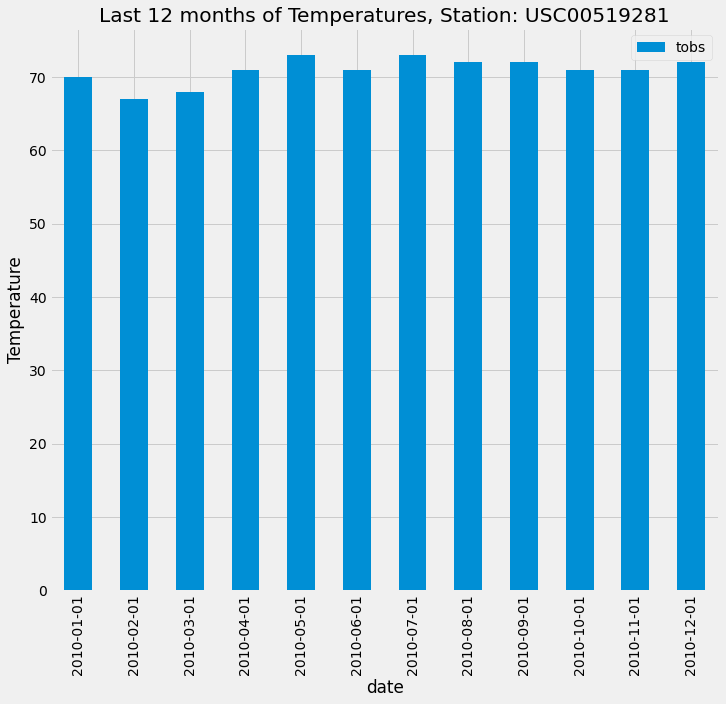

In [27]:
# Plot the dataframe as a horizontal bar chart using pandas plotting
temp_groupbydate.plot.bar(figsize=(10,10), title="Last 12 months of Temperatures, Station: "+ active_station)
plt.tight_layout()
plt.ylabel("Temperature")
plt.show()

# Close session

In [23]:
# Close Session
session.close()